# Project description
You’ve decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so you and your partners decide to try to attract investors. They’re interested in the current market conditions—will you be able to maintain your success when the novelty of robot waiters wears off?
You’re an analytics guru, so your partners have asked you to prepare some market research. You have open-source data on restaurants in LA.

## Initialization

In [1]:
%pip install usaddress

     |████████████████████████████████| 63 kB 4.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.0 MB 55.8 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 62.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=d8acd7257f100d928e83822436c2027fbf70bf515d5f0086ab2e309293d6d222
  Stored in directory: /home/jovyan/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install cufflinks plotly

     |████████████████████████████████| 81 kB 10.0 MB/s eta 0:00:01
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67922 sha256=5aa1fd0aa1ab2065384eaf629fcd01ff9c3805e1d878faad57513f06abb61980
  Stored in directory: /home/jovyan/.cache/pip/wheels/29/b4/f8/2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
Successfully built cufflinks
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import sidetable
import warnings
import usaddress
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)


# Step 1. Download the data and prepare it for analysis
Download the data on restaurants in LA. Make sure that the data type for each column is correct and that there are no missing values or duplicates. Process them if necessary.
File path: /datasets/rest_data_us.csv. Download dataset

In [5]:
try:
    data = pd.read_csv('rest_data_us.csv')
except:
    data = pd.read_csv('/datasets/rest_data_us.csv')

In [6]:
data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


There are 6 columns 9651 rows of data. All column names are ok, we expect missing values in chain column.

In [8]:
data.duplicated().sum()

0

No duplicates! Now we can  investigate data column by column and prepare it for the analysis.

## Missing values

In [9]:
#check missing values in data
data.stb.missing(style=True)

,missing,total,percent
chain,3,"9,651",0.03%
id,0,"9,651",0.00%
object_name,0,"9,651",0.00%
address,0,"9,651",0.00%
object_type,0,"9,651",0.00%
number,0,"9,651",0.00%


Missing values are only in chain column.

In [10]:
data.chain.value_counts(dropna = False)

False    5972
True     3676
NaN         3
Name: chain, dtype: int64

In [11]:
data[data['chain'].isnull()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


Not very famous names. Let's check if there are more objects with these names in our data, so they would belong to a chain.

In [12]:
data[data['object_name'].isin(["taqueria los 3 carnales", "jammin jimmy's pizza", "the lexington theater"])]

,id,object_name,address,chain,object_type,number


No more such names were found. So, these objects are really unique, they are not included in any chain, so we may replace NaN in 'chain' column with False.

In [13]:
data['chain'] = data['chain'].fillna(False)

In [14]:
data.chain.isna().sum()

0

Finally, no missing values!

## Editing object names

Let's check values in object_name column.

In [15]:
names=data.object_name.value_counts().sort_index()
names

#1 CAFE                      1
#1 CHINESE FAST FOOD         1
#1 DONUT                     1
#1 DONUTS                    1
#2 MOON BBQ                  1
                            ..
ZULY'S 99 AND UP DISCOUNT    1
ZUMA KITCHEN                 1
ZWEET CAFE                   1
ZWONNY KITCHEN INC           1
ZZAMONG                      1
Name: object_name, Length: 8672, dtype: int64

First let's turn names lowercase, it will make data parsing easier.

In [16]:
data['object_name'] = data['object_name'].str.lower()
data.head(2)

,id,object_name,address,chain,object_type,number
0,11786,habitat coffee shop,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9


### Issues

We see multiple issues with names. There are lots of spelling mistakes, so one and the same object is presented several times with different names.

In [17]:
data.query("object_name.isin(['a won japanase restaurant','a won japanese restaurant'])")

,id,object_name,address,chain,object_type,number
4824,16610,a won japanase restaurant,913 S VERMONT AVE,True,Restaurant,105
8771,20557,a won japanese restaurant,913 S VERMONT AVE,True,Restaurant,97


In [18]:
data.query("object_name.isin(['23rd st cafe', '23rd st. cafe'])")

,id,object_name,address,chain,object_type,number
2308,14094,23rd st cafe,936 W 23RD ST,False,Restaurant,32
7454,19240,23rd st. cafe,936 W 23RD ST,False,Restaurant,35


In [19]:
data.query("object_name.isin(['5 star market','5- star- market'])")

,id,object_name,address,chain,object_type,number
3561,15347,5 star market,2700 W VERNON AVE,False,Restaurant,28
7063,18849,5- star- market,2700 W VERNON AVE,False,Restaurant,1


In the above examples we see **objects with the same address but slightly different spelling**, so they are definitely one and the same thing. Important to note that these implicit duplicates may have different 'number' values.

Similar names with different addresses are not duplicates (people sometimes give similar names to their cafes or restaurants even when they are not chains), so it's important to check addresses, not only names.

In [20]:
data.query("object_name.isin(['7 star coffee', '7 star coffee #2', '7-star coffee #3'])")


,id,object_name,address,chain,object_type,number
6398,18184,7 star coffee,421 W 7TH ST,False,Cafe,16
6663,18449,7 star coffee #2,701 S BROADWAY UNIT UNIT,False,Cafe,29
9214,21000,7-star coffee #3,650 S HILL ST STE S-1,False,Cafe,18


The following 3 object with very similar names are really different. The following examples have 2 implicit duplicates(differ only in #17 and number of seats) and 2 more locations of the same chain.

In [21]:
data.query("object_name.isin(['souplantation # 17', 'souplantation'])")

,id,object_name,address,chain,object_type,number
1588,13374,souplantation,100 N LA CIENEGA BLVD # E-3,True,Restaurant,181
5624,17410,souplantation # 17,100 N LA CIENEGA BLVD # E-3,True,Restaurant,199
5827,17613,souplantation,2921 LOS FELIZ BLVD,True,Restaurant,219
8981,20767,souplantation,11911 SAN VICENTE BLVD STE 116,True,Restaurant,209


The issue is sometimes connected not with spelling, but **with extra words added to the object name**, like below: 

In [22]:
data.query("object_name.isin(['academy la - kitchen & living room bar', 'academy la'])")

,id,object_name,address,chain,object_type,number
9097,20883,academy la,6021 HOLLYWOOD BLVD,False,Restaurant,26
9226,21012,academy la - kitchen & living room bar,6021 HOLLYWOOD BLVD,False,Restaurant,173


In [23]:
data.query("object_name.isin(['alex sandwich','alex sandwich shop'])")

,id,object_name,address,chain,object_type,number
802,12588,alex sandwich,1242 S SANTEE ST # A,False,Restaurant,27
7721,19507,alex sandwich shop,1242 S SANTEE ST # A,False,Restaurant,4


The following example shows real duplicates with the same address, very similar names and equal number of seats!,  but now the **object type is different**:

In [24]:
data.query("object_name.isin(['adu burgers','adu burges'])")

,id,object_name,address,chain,object_type,number
7933,19719,adu burges,8020 S VERMONT AVE,False,Restaurant,19
9517,21303,adu burgers,8020 S VERMONT AVE,False,Fast Food,19


There are cases when objects differ not only in name spelling, but **the address is slightly different**.

In [25]:
data.query("object_name.isin(['#1 donut', '#1 donuts'])")

,id,object_name,address,chain,object_type,number
8082,19868,#1 donut,8509 S FIGUEROA ST,False,Fast Food,21
8516,20302,#1 donuts,8509 S FIGUEROA ST # 106,False,Fast Food,25


Let's take a closer look at the adresses with usaddress library:

In [26]:
usaddress.parse(data.iloc[8516]['address'])

[('8509', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('FIGUEROA', 'StreetName'),
 ('ST', 'StreetNamePostType'),
 ('#', 'OccupancyIdentifier'),
 ('106', 'OccupancyIdentifier')]

In [27]:
usaddress.parse(data.iloc[8082]['address'])

[('8509', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('FIGUEROA', 'StreetName'),
 ('ST', 'StreetNamePostType')]

So the difference is only in OccupancyIdentifier, which is marked in one case and absent in another, but it is definetly one and the same place, therefore donut and donuts are also duplicates.

There are lots of addresses with OccupancyIdentifier, which may hide duplicates.

In [28]:
data[data['address'].str.contains('#', na=False)]

,id,object_name,address,chain,object_type,number
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9
2,11788,street churros,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
6,11792,cpk,100 WORLD WAY # 126,False,Restaurant,100
14,11800,cuscatleca bakery,2501 W SUNSET BLVD #A,True,Bakery,26
17,11803,an's chan bang,244 S OXFORD AVE # 5,False,Restaurant,10
...,...,...,...,...,...,...
9621,21407,red rock,11301 W OLYMPIC BLVD # 210,True,Restaurant,41
9631,21417,mee & greet,3500 OVERLAND AVE # 150,False,Restaurant,2
9635,21421,the tea & coffee exchange,6801 HOLLYWOOD BLVD # 120,False,Cafe,4
9636,21422,chipotle #3094,6719 LA TIJERA BLVD # A-B,True,Restaurant,47


We see different patterns with numbers, letters, spaces following # sign which should be cleaned out to find out duplicates.

And finally we can find duplicates **belonging to a chain that are not marked as chain** when their name is misspelled.

In [29]:
data.query("object_name.isin(['aldewania restaurant','aldewaniah restaurand and market'])")

,id,object_name,address,chain,object_type,number
1276,13062,aldewania restaurant,2528 S GRAND AVE,True,Restaurant,42
6335,18121,aldewaniah restaurand and market,2528 GRAND AVE,False,Restaurant,38


In [30]:
data.query("object_name.isin(['natalie thai', 'natalee thai'])")

,id,object_name,address,chain,object_type,number
733,12519,natalee thai,998 S ROBERTSON BLVD,True,Restaurant,62
4115,15901,natalee thai,10101 VENICE BLVD,True,Restaurant,140
7642,19428,natalie thai,998 S ROBERTSON BLVD,False,Restaurant,148


So, to find issues and identify implicit duplicates we should take into account the fact that one and the same name can belong to different objects with different addresses (usually when it's a chain, but not necessarily), and different objects with different names can be located at the same address(e.g. in a large shopping center). I will call **implicit duplicates** those objects that have similar names and located at the same address, usually(not always) have the same values in 'chain' and 'object_type' columns. Equality of 'number' values is not a criterion at all, because there are multiple errors in the column that can not be corrected(within this work). Let's look at object names in rows with duplicated addresses.

In [31]:
duplicate_adress = data[data.duplicated('address', keep=False)].sort_values('address') 
duplicate_adress

,id,object_name,address,chain,object_type,number
1588,13374,souplantation,100 N LA CIENEGA BLVD # E-3,True,Restaurant,181
5624,17410,souplantation # 17,100 N LA CIENEGA BLVD # E-3,True,Restaurant,199
8201,19987,home turf sports bar,100 WORLD WAY,False,Bar,32
6515,18301,starbucks coffee,100 WORLD WAY,True,Cafe,9
6277,18063,gorden biersch,100 WORLD WAY,False,Restaurant,17
...,...,...,...,...,...,...
3133,14919,olle,984 S WESTERN AVE,False,Restaurant,17
6693,18479,holiday inn lax airport,9901 S LA CIENEGA BLVD,False,Restaurant,140
1123,12909,holiday inn lax,9901 S LA CIENEGA BLVD,False,Restaurant,4
7642,19428,natalie thai,998 S ROBERTSON BLVD,False,Restaurant,148


If we scroll through all rows in the table we see implicit duplicates that are hidden by multiple issues with object_names and addresses that need treating.

### Cleaning

First let's remove numbers with # sign from object names with re.sub() function for regular expressions.
Object names are strings that sometimes have numbers(#.....) which I want to delete. Examples: 'carls jr #97', 'wienerschnitzel #228', 'subway #32985', 'belasco bar#3', 'target store #t2774', 'yum yum donut #13c franchise', 'pizza man #8',  '#1 donut'.

So number after #sign can have 1 or more digit and sometimes is followed with a letter, and this pattern can come before, inside or after the name itself.

\s*#\d+ matches the pattern where there is a '#' symbol followed by one or more digits,
\s\d+\w matches the pattern where there are one or more digits followed by zero or more word characters(letters), 

One more problem is with final 'inc' or 'llc' with or without dots or commas and spaces, which are sometimes added to object names, sometimes not: 'inc' , 'llc',  ', inc',  ', llc', ', inc.',  'inc.', '.inc'. They are also described with pattern: (?:\s*\b(?:inc|llc)\b|[,.]\s*(?:inc|llc)[.,]?)

cleaned_name is the result obtained after replacing the pattern with empty string(re.sub()) and deleting extra spaces(strip()).

In [32]:
import re

def remove_numbers(name):
    pattern = pattern = r'\s*#\s*\d+|\s*#\d+\w*|(?:\s*\b(?:inc|llc)\b|[,.]\s*(?:inc|llc)[.,]?)'
    cleaned_name = re.sub(pattern, '', name)
    return cleaned_name.strip()

In [33]:
data['cleaned_name'] = data['object_name'].apply(lambda x: remove_numbers(x))
data['cleaned_name'].head()

0    habitat coffee shop
1               reilly's
2         street churros
3      triniti echo park
4                 pollen
Name: cleaned_name, dtype: object

In [34]:
data.iloc[7416]

id                                    19202
object_name     coffee bean & tea leaf #348
address                    9829 VENICE BLVD
chain                                  True
object_type                            Cafe
number                                    2
cleaned_name         coffee bean & tea leaf
Name: 7416, dtype: object

We can do almost the same thing with addresses to remove #... pattern after street names(8509 S FIGUEROA ST # 109, 505 S FLOWER ST # B300F, 3250 W OLYMPIC BLVD #313, 505 S FLOWER ST # B-15.  Regular expression is 

In [35]:
def remove_numbers(address):
    pattern = r'\s*#\s*\w+'
    cleaned_address = re.sub(pattern, '', address)
    return cleaned_address.strip()

In [36]:
data['cleaned_address'] = data['address'].apply(lambda x: remove_numbers(x))
data['cleaned_address'].head()

0    3708 N EAGLE ROCK BLVD
1             100 WORLD WAY
2       6801 HOLLYWOOD BLVD
3        1814 W SUNSET BLVD
4        2100 ECHO PARK AVE
Name: cleaned_address, dtype: object

### Dictionary
Now let's make a dictionary where the keys are 'bad object names' and values are 'good object names' to replace with. It will help to reveal duplicates and make chain establishments' names consistent.

In [37]:
name_dict =  {'800  degrees neapolitan pizzeria' : '800 degrees pizzeria',
             '800 degrees neapolitan pizze' : '800 degrees pizzeria',
             '2 for 1 pizza co' : '2 for 1 pizza company',
             '23rd st cafe' :  '23rd st. cafe',
             '33 taps silverlake' : '33 taps',  
             '5- star- market' : '5 star market', 
             '7-star coffee' : '7 star coffee',
             "afc sushi @ ralph\'s": 'afc ralphs',
             "afc sushi at ralph\'s": 'afc ralphs',
             "afc sushi at ralph's" : 'afc ralphs',
             'ralphs market' : 'afc ralphs',
             'afc at ralphs' : 'afc ralphs',
             'afc sushi & vons': 'afc ralphs',
             'afc sushi @ ralph' : 'afc ralphs',
             'afc @ ralphs': 'afc ralphs',
             "afc sushi @ ralph's" : 'afc ralphs',
             'afc sushi @ ralphs' :'afc @ ralphs',
             'afc sushi at walgreens' : 'afc ralphs',
             'afc sushi@ralphs' : 'afc ralphs',
             'atticus creamery': 'atticus',
             'atticus icecream and pies': 'atticus',
             'academy la - kitchen & living room bar' : 'academy la',
             'air canada maple leaf lounge' : 'air canada lounge',
             'alameda snack shop' : 'alameda snack bar',
             'aldewaniah restaurand and market' : 'aldewania restaurant',
             'alley dog n burger' : 'alley dog',
             "amalia's restaurants" : "amalia's restaurant",
             'amandine patisserie cafe dtla' : 'amandine patisserie cafe',
             'andante coffee roasters' : 'andante coffee',
             "auntie anne's pretzel" : "auntie anne's",
             'baja fresh mexican grill' : 'baja fresh',
             'bak kung korean bbq 2' : 'bak kung', 
             'bamboo chinese cuisine' : 'bamboo',
             'bamboo express' : 'bamboo',
             'bamboo express & chinese cuisine' : 'bamboo',
             'baskin robbins 31 flavors' : 'baskin robbins',
             'baskin robbins 31 flavors 89' : 'baskin robbins',
             'bbq chicken l.a.' : 'bbq chicken',
             'bbq chicken la' :  'bbq chicken',
             "big mama's & papa' pizzeria" : "big mama's & papa's pizzeria",
              "big mamas & papa's/mariposa" : "big mama's & papa's pizzeria",
             'big mamas & papas pizzeria' : "big mama's & papa's pizzeria",
              "big mama\'s and papa\'s pizzer": "big mama\'s & papa\'s pizzeria",
             'blu jam cafe - brentwood' : 'blu jam cafe',
             'boba time - highland' : 'boba time',
             'boba time- usc' :'boba time',
             'bobatime-dewey' : 'boba time',
             'burger king 11299' : 'burger king',
             'burger king 13511': 'burger king',
             'burger king 2554': 'burger king',
             "church's fried chicekn" :  "church's fried chicken",  
             'carls jr' : "carl's jr",
             "carl's jr." : "carl's jr",
            "carl's jr/green burrito" : "carl's jr",
            'coffee bean and tea leaf' : 'coffee bean & tea leaf',
            'coffee bean and tea leaf - arrival' : 'coffee bean & tea leaf',
            'the coffee bean & tea leaf - arrival' : 'coffee bean & tea leaf',
            'the coffee bean & tea leaf - ticketing' : 'coffee bean & tea leaf',
             'the coffee bean & tea leaf': 'coffee bean & tea leaf',
             'the coffee bean & tea leaf 8d' : 'coffee bean & tea leaf',
            'the coffee bean & tea leaf storage': 'coffee bean & tea leaf',
             'california roll & sushi fish' : 'california roll & sushi',
             'california roll factory' : 'california roll & sushi',
             'chick n roll': 'chicken n roll',
             'chicken n\' roll': 'chicken n roll',
             'daily donut' :  'daily donuts',
             'daily donut house' : 'daily donuts',
             'daily donuts house' : 'daily donuts',
             'dominos pizza': 'domino\'s pizza',
             'earth bar' :  'earthbar',
             'earth organic juice bar'  : 'earthbar',                   
             'el buen gusto restaurant'  : 'el buen gusto', 
             'ihop restaurant' : 'ihop',
             "jersey mike's subs store-20229" : "jersey mike's subs",
             'kentucky fried chicken t32' : 'kentucky fried chicken',
             'los angeles country club main kitchen': 'los angeles country club',
             'la adelita food co' :   'la adelita',
             'la adelita foods' : 'la adelita',
              'las champas 12' : 'las champas',
             'las champas 2' : 'las champas',                                     
             'las champas restaurant' : 'las champas',                      
             'las champas usa food service' : 'las champas',
             'little caesar' : 'little caesars',
             "little caesar's"  : 'little caesars',
             "little caesar's pizza": 'little caesars',
             'little caesars pizza' : 'little caesars',
             'louisana red seafood' : 'louisiana', 
             'louisiana famous fried chick' : 'louisiana',                          
             'louisiana fried chicken' : 'louisiana',                               
             'louisiana fried chicken & china bowl' : 'louisiana',                 
             'louisiana fried chicken & fi' : 'louisiana',                          
             'louisiana fried chicken & hong 2' : 'louisiana',                       
             'louisiana fried chicken taco' : 'louisiana',
             'dragon loco chinese food': 'dragon loco',
             'eastside market inc': 'eastside market llc',
             'subway sandwich': 'subway',
             'pho pasteur express restaurant': 'pho family restaurant',
             'jamba juice company': 'jamba juice',
             'bablu cafe': 'babalu cafe',
             'rahel veggie cuisin': 'rahel vegan cuisine',
             'playa dora': 'playa dorada',
             'meals by genet inc': 'meals by genet',
             'siroodang': 'sirudang',
             "mcdonald’s" : "mcdonald's",
             "mc donald's" : "mcdonald's", 
             "mcdonald's (crenshaw)" : "mcdonald's",                                 
             "mcdonald's restaurant" : "mcdonald's",                                 
             "mcdonald's/" : "mcdonald's",                                         
             "mcdonalds" : "mcdonald's",
             "mcdonald���s" : "mcdonald's",
             "mcdonald<u+2019>s": "mcdonald's",
             'monte carlo cafe': 'monte carlo',
             'oumi sushi @ sprouts 275'  : 'oumi sushi @ sprouts',    
             'pa ord noodle 3' : 'pa ord noodle', 
             "peet's coffee and tea" : "peet's coffee",                                
             "peet's coffee angel city" : "peet's coffee",
             'pressed juicery - the grove' : 'pressed juicery',               
             'pressed juicery llc' : 'pressed juicery',
             'starbucks  @ usc' : 'starbucks',                                        
             'starbucks (coffee bar) level 1 - ucla' : 'starbucks',                   
             'starbucks -  departure' : 'starbucks',                                  
             'starbucks - arrival' : 'starbucks',                                     
            'starbucks 22477' : 'starbucks',                                        
            'starbucks cafe 84' : 'starbucks',                                      
            'starbucks coffee' : 'starbucks',                                       
            'starbucks coffee corporation' : 'starbucks',                          
            'starbucks evening ' : 'starbucks',                                     
             'starbucks store' : 'starbucks',                                         
             'starbucks-17413' : 'starbucks',                                         
             'starbucks/la cafe' : 'starbucks',            
             'subway  60937' : 'subway',                   
             'subway - 46186' : 'subway',                                          
             'subway - 48845' : 'subway',                                         
             'subway -52105' : 'subway',                                           
              'subway 16373' : 'subway',                                            
             'subway 2530' : 'subway',                                            
             'subway 46382' : 'subway',                                           
             'subway 46383' : 'subway',                                            
             'subway sandwich' : 'subway', 
             'subway sandwich shop' : 'subway',                                   
             'subway sandwiches' : 'subway',                                      
             'subway sandwiches & salads' : 'subway',                             
             'subway sandwiches 13941' : 'subway',                                
             'subway sandwiches and salads' : 'subway',                            
            'subway sandwiches salads' : 'subway',                               
            'subway sanwiches' : 'subway',                                   
             'subway store' : 'subway',                                           
             'subway-48844' : 'subway',                                            
             'taco bell 28731' : 'taco bell',                                 
             'taco bell/pizza hut' : 'taco bell',
             'tom n toms coffee' : 'tom n toms',                                      
             'tom n toms vermont galleria' : 'tom n toms',                           
             'tom n toms-coffee' : 'tom n toms',
             'trimana 515 figueroa' : 'trimana',                                    
             'trimana at wateridge' : 'trimana',                                    
             'trimana city hall east' : 'trimana',                                 
             'trimana commonwealth' : 'trimana',                                    
             'trimana express' : 'trimana',                                         
              'trimana grill' : 'trimana',                                           
             'trimana of 11755 wilshire ' : 'trimana',                             
             'trimana of californiamart' : 'trimana',                              
             'trimana of hope st' : 'trimana',                                     
              'trimana restaurant' : 'trimana',                                      
              'trimana/lausd' : 'trimana',
             'yogurt land': 'yogurtland',
             'yogurtland baldwin hills' : 'yogurtland',                                
             'yogurtland boyle heights' : 'yogurtland',                                
             'yogurtland central /  slauson' : 'yogurtland',                           
             'yogurtland ladera heights' : 'yogurtland',                               
             'yogurtland little tokyo' : 'yogurtland',                                
             'yogurtland sunset' : 'yogurtland',                                       
             'yogurtland usc gateway' : 'yogurtland',                                
             'yogurtland westchester' : 'yogurtland',
             'yum yum chinese food' :  'yum yum donuts',                                  
              'yum yum donuts franchise' : 'yum yum donuts',                               
             'yum yum donuts franchise 9147e' : 'yum yum donuts',                         
             'yum yum donuts storage' : 'yum yum donuts',                                 
             'yum yum donuts-b' : 'yum yum donuts',                                       
              'yum yum donuts-e' : 'yum yum donuts',                                        
              'yum yum donutsc franchise' : 'yum yum donuts',                             
             'yum yum donutsd' : 'yum yum donuts',                                        
             'yum yum donutse' : 'yum yum donuts',
             'yum yum donut franchise': 'yum yum donuts',
             'back house/kitchen 28': 'the backhouse restaurant',
             'the backhouse': 'the backhouse restaurant',
             'la serenata de geribaldi': 'la serenata',
             'salad farm': 'saladfarm',
             'jin jiang seafood restaurant': 'jin jiang chinese restaurant',
             'founders room lounge': 'founders room',
             'concert hall servery': 'concert hall',
             'hop woo bbq & seafood': 'hop woo',
             'royal donuts & croissant': 'royal donuts & more',
             'century kitchen-olympic coll': 'olympic collection buffet',
             'luxe sunset boulevard hotel': 'luxe hotel',
             'johnnies ny pizzeria': 'johnnie\'s new york pizzeria',
             'papa johns pizza': 'papa john\'s pizza',
             'umami poki / asakuma sushi delivery': 'asakuma sushi delivery',
             'the plaza pantry': 'plaza pantry',
             'garden terrace @ the getty': 'the cafe @ the getty',
             'lady chocolatt cafe': 'lady chocolatt',
             'rosemary grill': 'rosemary\'s grill',
             'panda garden chinese fast food': 'panda garden',
             'alex sandwich shop': 'alex sandwich',
             'florence donuts': 'happy donut',
             'jack-in the box': 'jack in the box',
             'poke\'me': 'poke me',
             'happy tacos to go': 'happy tacos',
             "it's thai hometaurant": "it's thai home restaurant",
             'ahmanson west bar': 'ahmanson founders room',
             'louisiana fried chicken': 'louisiana',
             'shaherzard restaurant': 'shaherzard',
             'la teclena restaurant': 'la teclena',             
             'the foodshop, inc': 'the food shop',
             'angelino\'s donuts': 'angelino\'s donut',
             'e t donuts': 'et\'s donut',
             'zamora bros. meat market': 'zamora bros',
             'sd coffee shop': 'sd coffee',
             'le orential bistro': 'le oriential bistro',
             'cleo bar on 2nd floor': 'cleo',
             'pattaya bay thai restaurant': 'pattaya thai restaurant',
             'china bowl express': 'china bowl',             
             'boys burgers no.1': 'boy\'s burgers',
             'josephts cafe': 'joseph\'s cafe',
             'western pollo ala brasa': 'pollo a la brasa',
             'm\'dears deserts bakery & bis': 'm\'dears bakery & bistro',
             'jersey mike\'s sub': 'jersey mike\'s subs',
             'adu burges': 'adu burgers',
             'cafe anzio': 'anzio cafe',
             'third generation sake bar / restaurant': '3rd generation',
             'wing stop': 'wingstop',
             'sabor colombiano restaurant': 'sabor colombiano',
             'coffe time': 'coffee time',
             'dolcini cafe espresso': 'dolcini caffe espresso',
             'jack n` jills` too': 'jack\'n jill too',
             'louisiana fried chicken & chinese food': 'louisiana fried chicken',
             'a won japanase restaurant': 'a won japanese restaurant',
             'town noodel': 'town noodle',
             'vim thai restaurant, inc.': 'vim thai restaurant',
             'the dragon restaurant': 'the dragon',
             'der wienerschnitzel' : 'wienerschnitzel',
             'holiday inn lax airport': 'holiday inn lax',
             'natalee thai': 'natalie thai'}
def replace_name(x):
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return x

In [38]:
data. loc[7933]['cleaned_name']

'adu burges'

In [39]:
example = data['cleaned_name'].loc[7933]
example

'adu burges'

In [40]:
replace_name(example)

'adu burgers'

Our function works well on examle, let's apply it to the whole column.

In [41]:
data['name_flt']=data['cleaned_name'].apply(replace_name)
data.head()

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt
0,11786,habitat coffee shop,3708 N EAGLE ROCK BLVD,False,Cafe,26,habitat coffee shop,3708 N EAGLE ROCK BLVD,habitat coffee shop
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9,reilly's,100 WORLD WAY,reilly's
2,11788,street churros,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 HOLLYWOOD BLVD,street churros
3,11789,triniti echo park,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 W SUNSET BLVD,triniti echo park
4,11790,pollen,2100 ECHO PARK AVE,False,Restaurant,20,pollen,2100 ECHO PARK AVE,pollen


So, we cleaned object names and adressed(removed  #..., inc/llc), then replaced 'bad' object names with 'good' names to reveal implicit duplicates. Now the duplicates have the same values in 'cleaned_address' and 'name_flt' columns. They often have different values in 'number' column, and now we have no opportunity to check which of them is correct. Let's drop duplicate rows(by name,address and chain) saving the first occurence, so the biggest or the smallest number of seats will be deleted at random to keep the balance. Make a new filtered dataframe df. 

In [42]:
df = data.drop_duplicates(subset=['cleaned_address', 'name_flt', 'chain'], keep='first', inplace=False)
df.head()

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt
0,11786,habitat coffee shop,3708 N EAGLE ROCK BLVD,False,Cafe,26,habitat coffee shop,3708 N EAGLE ROCK BLVD,habitat coffee shop
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9,reilly's,100 WORLD WAY,reilly's
2,11788,street churros,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 HOLLYWOOD BLVD,street churros
3,11789,triniti echo park,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 W SUNSET BLVD,triniti echo park
4,11790,pollen,2100 ECHO PARK AVE,False,Restaurant,20,pollen,2100 ECHO PARK AVE,pollen


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9523 entries, 0 to 9650
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9523 non-null   int64 
 1   object_name      9523 non-null   object
 2   address          9523 non-null   object
 3   chain            9523 non-null   bool  
 4   object_type      9523 non-null   object
 5   number           9523 non-null   int64 
 6   cleaned_name     9523 non-null   object
 7   cleaned_address  9523 non-null   object
 8   name_flt         9523 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 678.9+ KB


Our filtered df now contains 9523 rows(out of 9651),but we saw earlier, that some duplicates may have different values in chain column. Let's look at them.

In [44]:
df[df.duplicated(subset=['cleaned_address', 'name_flt'], keep=False)].sort_values('address')

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt
9417,21203,carls jr #97,1005 S FAIRFAX AVE,False,Restaurant,94,carls jr,1005 S FAIRFAX AVE,carl's jr
5380,17166,carl's jr #97,1005 S FAIRFAX AVE,True,Restaurant,70,carl's jr,1005 S FAIRFAX AVE,carl's jr
1292,13078,los angeles country club main kitchen,10101 WILSHIRE BLVD,True,Restaurant,182,los angeles country club main kitchen,10101 WILSHIRE BLVD,los angeles country club
7551,19337,los angeles country club,10101 WILSHIRE BLVD,False,Restaurant,4,los angeles country club,10101 WILSHIRE BLVD,los angeles country club
6206,17992,dragon loco,1011 W FLORENCE AVE,False,Restaurant,25,dragon loco,1011 W FLORENCE AVE,dragon loco
3317,15103,dragon loco chinese food,1011 W FLORENCE AVE,True,Restaurant,24,dragon loco chinese food,1011 W FLORENCE AVE,dragon loco
5118,16904,ralphs market #759,10861 WEYBURN AVE,True,Restaurant,13,ralphs market,10861 WEYBURN AVE,afc ralphs
7928,19714,afc sushi at ralph's #759,10861 WEYBURN AVE,False,Restaurant,11,afc sushi at ralph's,10861 WEYBURN AVE,afc ralphs
824,12610,the backhouse restaurant,10913 W PICO BLVD,True,Restaurant,40,the backhouse restaurant,10913 W PICO BLVD,the backhouse restaurant
5407,17193,back house/kitchen 28,10913 W PICO BLVD,False,Restaurant,31,back house/kitchen 28,10913 W PICO BLVD,the backhouse restaurant


Almost always when duplicates have different values in 'chain' column  we see 'True' in rows with smaller indices than those with 'False' values. That means that objects belonging to a chain come earlier in dataset and will be kept if we drop duplicates. Only restaurants 'carl's jr' and 'saladfarm' which are chains have False values in their first occurence(it's an error), so if we now drop duplicates the wrong value will be kept. Let's first replace the wrong values.


In [45]:
df.loc[df['name_flt'].isin(["carl's jr", 'saladfarm']), 'chain'] = True
df.loc[df['name_flt'].isin(["carl's jr", 'saladfarm']), 'chain']

138     True
161     True
498     True
535     True
723     True
957     True
1044    True
2304    True
2419    True
2753    True
3676    True
3832    True
3967    True
3972    True
4041    True
4133    True
4944    True
4984    True
4998    True
5277    True
5380    True
5518    True
5641    True
6892    True
7056    True
7448    True
7586    True
8371    True
8695    True
8797    True
9269    True
9417    True
Name: chain, dtype: bool

Now we are sure that the right value of 'chain' will be preserved, so we may drop duplicates by name and address.

In [46]:
df = df.drop_duplicates(subset=['cleaned_address', 'name_flt'], keep='first', inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9498 entries, 0 to 9650
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9498 non-null   int64 
 1   object_name      9498 non-null   object
 2   address          9498 non-null   object
 3   chain            9498 non-null   bool  
 4   object_type      9498 non-null   object
 5   number           9498 non-null   int64 
 6   cleaned_name     9498 non-null   object
 7   cleaned_address  9498 non-null   object
 8   name_flt         9498 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 677.1+ KB


Now there are only 9498 rows in data_flt (instead of 9651 in initial data), so 153 rows were dropped. The filtered dataframe is ready for the analysis.

# Step 2 Data analysis
## Investigate the proportions of the various types of establishments. Plot a graph

There are 6 types of establishments in our df.

In [47]:
est=df.groupby(['object_type'])['id'].nunique().reset_index()
est

,object_type,id
0,Bakery,282
1,Bar,287
2,Cafe,423
3,Fast Food,1042
4,Pizza,314
5,Restaurant,7150


And we can find a share of each type of establishment.

In [48]:
est_prc=df.object_type. value_counts(normalize=True).round(decimals=3).reset_index()
est_prc

,index,object_type
0,Restaurant,0.753
1,Fast Food,0.110
2,Cafe,0.045
3,Pizza,0.033
4,Bar,0.030
5,Bakery,0.030


The best way to show proportions of various types of establishments is piechart.

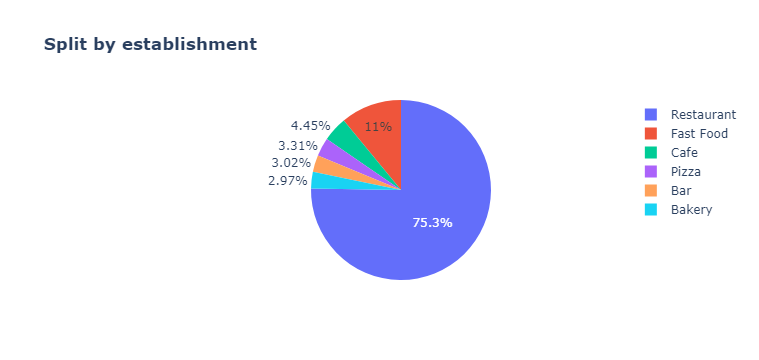

In [49]:
fig = go.Figure(data=[go.Pie(labels=est['object_type'], values=est['id'])])
fig.update_layout(
title="<b> Split by establishment</b>")
fig.show()

**So**, we see that restraurants make 3/4 of all the establishments. Then come fastfood(11%) and cafes(). Proportions of pizza, bar and bakery don't differ much, it's around 3%.

I think the share of restaurants is so big because the concept of 'restaurant' itself is very old and general, it just means an establishment where food is prepared and served to customers in exchange for money. It can be further specified what food, how it is prepared, how it is served, for what clients in particular and so on. The other types of establishments in the project are narrower concepts with more specific characteristics, some of them are also relatively new (pizza, fastfood), so they are not so widely spread as resaurants. Generally, the difference between object types is not always clear, and in cases when the establishment can be caracterized in diferent ways it can be easier to call it just a restaurant.

## Investigate the proportions of chain and nonchain establishments. Plot a graph.

In [50]:
chart_data = df.groupby(['chain'])['id'].nunique().reset_index()
chart_data


,chain,id
0,False,5909
1,True,3589


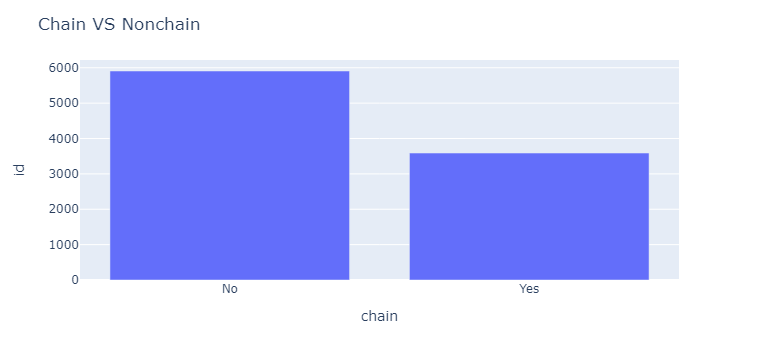

In [51]:
chart_data['chain']=chart_data['chain'].apply(lambda x: 'Yes' if x==True else 'No')
fig=px.bar(chart_data, x = 'chain', y = 'id')
fig.update_layout(title='Chain VS Nonchain')
fig.show()

In [52]:
df.chain.value_counts(normalize = True)

False    0.622131
True     0.377869
Name: chain, dtype: float64

**So**, nonchain establishments make about 62% of all objects, chain establishments make 38% of all objects(5909 VS 3589).

It happens because historically all establishments were nonchain, and then only some successful restaurant owners opened new locations and made a chain. Some chains become very popular, to repeat already existing structure is easier than to invent and organize something new, so over time more and more establishments are converted into chains and drive more expensive nonchain objects out off the market, but there is a difference between object types as we will see below.

## Which type of establishment is typically a chain?

Let's see how many of establishments of each type belong to a chain.

In [53]:
chain_type=data.groupby(['chain','object_type'])['id'].nunique().reset_index()
chain_type

,chain,object_type,id
0,False,Bar,215
1,False,Cafe,169
2,False,Fast Food,461
3,False,Pizza,167
4,False,Restaurant,4963
5,True,Bakery,283
6,True,Bar,77
7,True,Cafe,266
8,True,Fast Food,605
9,True,Pizza,153


We see that the share of chain objects in each type differs a lot: all bakeries belong to a chain chain, but the majority of bars do not(77 VS 215 ). Let's visualize the distribution with barplot.

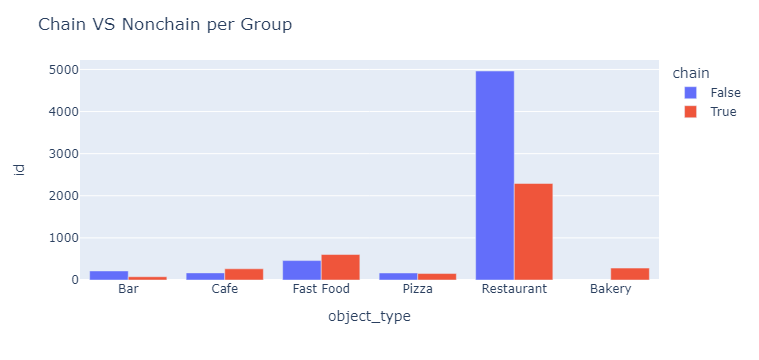

In [54]:
fig = px.bar(chain_type, x='object_type', y='id', color='chain', barmode='group')
fig.update_layout(title='Chain VS Nonchain per Group')
fig.show()

**Now it's clear** that Bakery is typically a chain (there are no nonchain bakeries). The share of chain objects is also very big among cafes(266 VS 169) and fastfood(605 VS 461). On the other pole are bars and restaurants, where nonchain objects prevail(215 VS 77, 4963 VS 2292). Pizzas are split almost in half.

Bakery is the narrowest category with specific caracteristics which can easily be formalized and repeated, so nonchain bakeries cost more to their owners(and to clients) and were totally driven out of the market. Almost the same with fastfood and cafes, where the share of cheaper chain establishments is higher than nonchain. On the other hand, nonchain restaurants and bars can offer their customers more expensive and sometimes exclusive food and serving, they are oriented on richer clients that appreciate individual style, so the share of chain massmarket establishments among bars and restaurants is smaller.

## What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?


Let's find out if many chain establishments usually have small number of seats or a few chain establishments have a lot of seats. We group chain data by name and find number of establishments and average(median) number of seats per object.

In [55]:
chain_seats=df[df.chain==True].groupby(['name_flt'])['number'].agg(['count','median']).reset_index()
chain_seats.columns=['name','number','average_seating']
chain_seats.to_excel('chain_seats.xlsx', index=False)
chain_seats

,name,number,average_seating
0,1810 restaurant,1,45.0
1,333,1,180.0
2,3rd st market & deli,1,7.0
3,4 caminos restaurant,1,18.0
4,5 line restaurant,1,41.0
...,...,...,...
1945,zankou chicken,2,53.5
1946,zen bakery (retail),1,19.0
1947,zermenos restaurant,1,10.0
1948,zion market deli & island,1,16.0


Let's check if there is some correlation between the parameters.

In [56]:
chain_seats['number'].corr(chain_seats ['average_seating'])


-0.013350277447460588

No correlation, but let's visualize the distribution to find any pattern in it.

/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



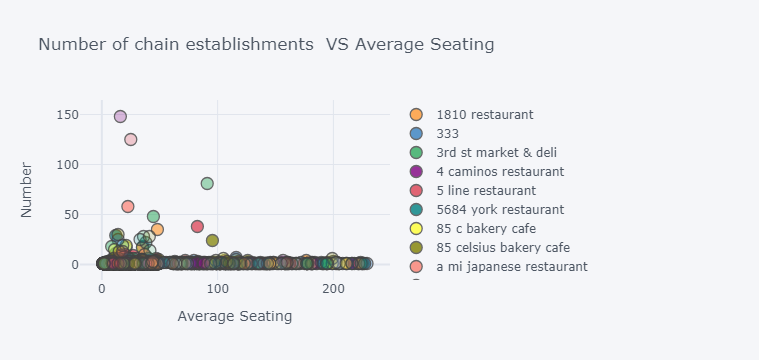

In [57]:
import numpy as np
chain_seats.iplot(
    x='average_seating',
    y='number',
    # Specify the category
    categories='name',
    xTitle='Average Seating',
    yTitle='Number',
    title='Number of chain establishments  VS Average Seating')

The plot shows that the majority of chain objects have small number of establishments with no matter what number of seats. There are some outliers like 'Subway' chain  - 148 objects with 16 average seating, Starbucks - 125 objects with 25 avg.seating, Mcdonald's - 81 object with 91 avg.seating. But in the right upper corner of the plot there are no circles, that is chains with more than 100 avg.seating don't have many objects. Still, we can't see correlation pattern between number of objects in a chain and average number of seats per object.  

We can see how different object types are distributed on the plot if we add 'object_type' parameter in grouping.

In [58]:
chain_type_seats=df[df.chain==True].groupby(['name_flt','object_type'])['number'].agg(['count','median']).reset_index()
chain_type_seats.columns=['name','object_type','number','average_seating']
chain_type_seats

,name,object_type,number,average_seating
0,1810 restaurant,Restaurant,1,45.0
1,333,Restaurant,1,180.0
2,3rd st market & deli,Restaurant,1,7.0
3,4 caminos restaurant,Restaurant,1,18.0
4,5 line restaurant,Restaurant,1,41.0
...,...,...,...,...
1953,zankou chicken,Restaurant,2,53.5
1954,zen bakery (retail),Bakery,1,19.0
1955,zermenos restaurant,Restaurant,1,10.0
1956,zion market deli & island,Restaurant,1,16.0


/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



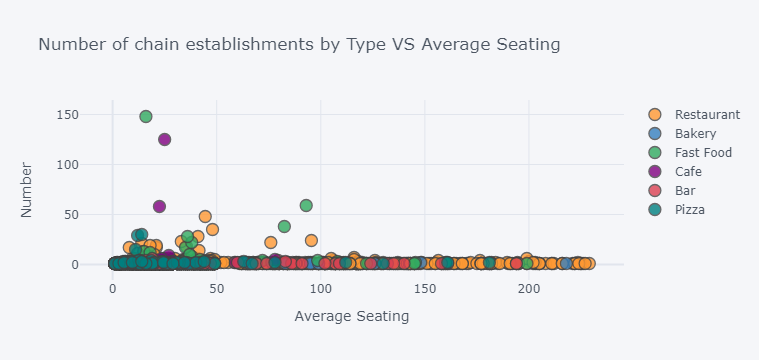

In [59]:
chain_type_seats.iplot(
    x='average_seating',
    y='number',
    # Specify the category
    categories='object_type',
    xTitle='Average Seating',
    yTitle='Number',
    title='Number of chain establishments by Type VS Average Seating')

The plot shows that green balls(pizza) are concentrated in the left end of the range,  yellow balls(restaurants) go up to the maximum number of seats, but they are also spread across the full range. Chain cafes are less likely to have many seats and their number is bigger. The max values for number of establishments is characteristic of fastfood. **Generally**, we can't see any definite correlation between number of seats and number of establishments in a chain.

OK, let's continue the discussion and split data into four groups: few establishments and few seats, few establishments and many seats, many establishments and few seats, many establishments and many seats. The question is: what is few or many? Let's first the categories in relation to the median value for our parameters 'number' and 'average_seating'.

In [60]:
S = chain_seats.average_seating.median()
S

24.0

In [61]:
N = chain_seats.number.median()
N

1.0

We take S and N as thresholds for splitting values into groups and define the function:

In [62]:
def find_group_1(row):
    S = chain_seats.average_seating.median()
    N = chain_seats.number.median()
    if row['number'] <= N and row['average_seating'] <= S:
        return 'ns'
    elif row['number'] <= N and row['average_seating'] > S:
        return 'nS'
    elif row['number'] > N and row['average_seating'] <= S:
        return 'Ns'
    else:
        return 'NS'


In [63]:
# Applying th e function to out data
chain_seats['group'] = chain_seats.apply(find_group_1, axis=1)
chain_seats['group'].value_counts()

ns    739
nS    732
Ns    244
NS    235
Name: group, dtype: int64

We see that groups with few seats are 2,5 times bigger than groups with many seats, so among chains there are 2.5 times more establishments with a few objects and a big number of seats than establishments with many objects and a few seats. But we assigned 'sn' group only for chains with just 1 object and less than 24 seats, while the actual range is 1-148 and 1-229. 

In [64]:
chain_seats.describe()

,number,average_seating
count,1950.000000,1950.000000
mean,1.840513,40.088462
std,5.539790,44.188484
min,1.000000,1.000000
25%,1.000000,14.000000
50%,1.000000,24.000000
75%,1.000000,43.000000
max,148.000000,229.000000


What if we take the mean instead of the median as a threshold?

In [65]:
def find_group_2(row):
    S = chain_seats.average_seating.mean()
    N = chain_seats.number.mean()
    if row['number'] <= N and row['average_seating'] <= S:
        return 'ns'
    elif row['number'] <= N and row['average_seating'] > S:
        return 'nS'
    elif row['number'] > N and row['average_seating'] <= S:
        return 'Ns'
    else:
        return 'NS'
chain_seats['group_mean'] = chain_seats.apply(find_group_2, axis=1)
chain_seats['group_mean'].value_counts()

ns    1046
nS     425
Ns     350
NS     129
Name: group_mean, dtype: int64

Now the relation between the groups have changed. 
- nS group is still bigger than Ns, but the difference is not so significant. 
- SN group is the smallest 
- sn group with small number of objects and small seating stands out as the biggest(2.5 times bigger than nS)
But this is true for chains with object number <= 1.84 and avg_seating <=40, that is  2 objects in a chain are still  regarded as many, while actual range is up to 148 objects in a chain. This doesn't seem reasonable. Let's add 1 point to 'small' chains and assign N to chains with >= 3 objects.

In [66]:
def find_group_3(row):
    N= 2
    S = chain_seats.average_seating.mean()
    if row['number'] <= N and row['average_seating'] <= S:
        return 'ns'
    elif row['number'] <= N and row['average_seating'] > S:
        return 'nS'
    elif row['number'] > N and row['average_seating'] <= S:
        return 'Ns'
    else:
        return 'NS'
chain_seats['group_mean'] = chain_seats.apply(find_group_3, axis=1)
chain_seats['group_mean'].value_counts()

ns    1278
nS     513
Ns     118
NS      41
Name: group_mean, dtype: int64

In [67]:
513/118


4.3474576271186445

Now nS group is 4.34 times bigger than Ns, so we may say that **chains that have many establishments with a small number of seats appear significantly more often than chains having a few establishments with a lot of seats.  But chains with a few objects and a few seats constitute the biggest group (2 times bigger than nS and Ns groups summed**). The same result we could observe in out scatterplot if we devide the whole plot into 4 parts: the right upper quarter of the plot has the least number of dots(chains), the left low quarter has max number of dots, there left upper quarter(Ns) is less populated than the right lower quarter(nS), the difference between them depends on the group border. So, chain establishments can have absolutely any number of seats and there's **no correlation between  number of seats and average seating**.

## Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats? Plot graphs.


We saw that there was some difference in number of seats between chain objects of different type. Let's find the average number of seats for each type of restaurant(chain and nonchain).

In [68]:
seating_type=df.groupby(['object_type'])['number'].median().sort_values(ascending = False).reset_index()
seating_type

,object_type,number
0,Restaurant,29
1,Bar,28
2,Cafe,21
3,Fast Food,21
4,Pizza,19
5,Bakery,18


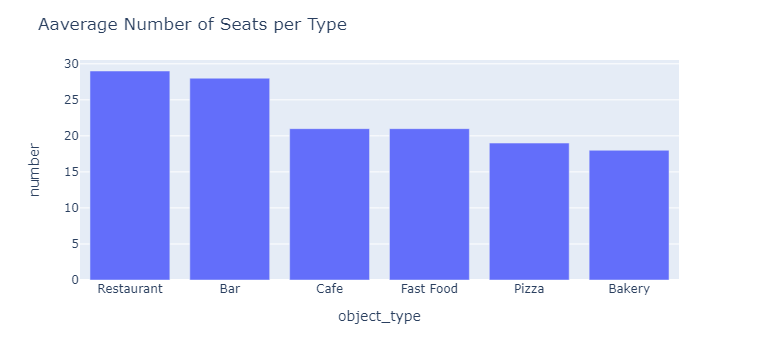

In [69]:
fig = px.bar(seating_type, x='object_type', y='number')
fig.update_layout(title='Aaverage Number of Seats per Type')
fig.show()

On average, restaurants have the greatest number of seats(29), bars are not far behind(28). Cafes and fastfood have equal avg. number od seats(21), bakery is the smalest(18 seats). What if we add 'chain' parameter to grouping and see the diference between chain/nonchain objects in average number of seats by type.

In [70]:
seating_type_ch=df.groupby(['object_type','chain'])['number'].median().sort_values(ascending = False).reset_index()
seating_type_ch.to_excel('seating_type_ch.xlsx', index=False)
seating_type_ch

,object_type,chain,number
0,Bar,False,33.0
1,Restaurant,False,31.0
2,Restaurant,True,28.0
3,Fast Food,True,24.0
4,Cafe,True,22.0
5,Pizza,False,20.5
6,Bar,True,20.0
7,Fast Food,False,19.0
8,Cafe,False,18.5
9,Bakery,True,18.0


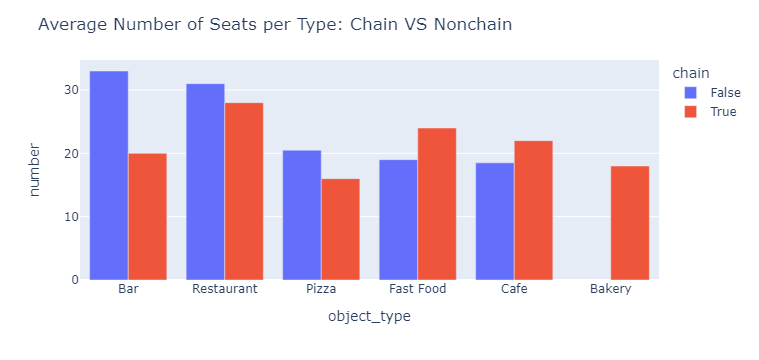

In [71]:
fig = px.bar(seating_type_ch, x='object_type', y='number', color='chain', barmode='group')
fig.update_layout(title='Average Number of Seats per Type: Chain VS Nonchain')
fig.show()

Although average restaurant is bigger than average bar, nonchain bars on average have more seats than nonchain restaurants. Chain cafes and fastfoods have more seats than nonchain establishments, all bakeries are chain, and the other types(bar, restaurant and pizza) have more seats in nonchain objects.

## Put the data on street names from the address column in a separate column.


The usaddress library will help us to split the address into parts and extract street name.

Let's create one example street to test the library.

In [72]:
str_ex=df.iloc[1000]['address']
str_ex

'5106 S CENTRAL AVE S'

In [73]:
usaddress.parse(str_ex)

[('5106', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('CENTRAL', 'StreetName'),
 ('AVE', 'StreetNamePostType'),
 ('S', 'StreetNamePostDirectional')]

In [74]:
#Assign the result of parsing to a new variable  now it's a list of tuples with the component and it's name. For example, "StreetName"-"Rock". I recommend to turn it into dictionary - it will be easier to call needed component.

raw_address=usaddress.parse(str_ex)
raw_address

[('5106', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('CENTRAL', 'StreetName'),
 ('AVE', 'StreetNamePostType'),
 ('S', 'StreetNamePostDirectional')]

It's a list with paired components. Now we create a new dictionary and for each component in raw_address we save component's name as key (i[1]) and component itself as value of the dictionary (i[0]).

In [75]:

dict_address={}
for i in raw_address:
    dict_address.update({i[1]:i[0]})

In [76]:
dict_address

{'AddressNumber': '5106',
 'StreetNamePreDirectional': 'S',
 'StreetName': 'CENTRAL',
 'StreetNamePostType': 'AVE',
 'StreetNamePostDirectional': 'S'}

In [77]:
dict_address['StreetName']

'CENTRAL'

Now the dictionary contains address's components and we can extract any of them by calling the dictionaty's key. We need the street name in a separate column, so let's write a special function that will take every row, find address and extract only the street name with StreetNamePreDirectional, if there is any, to distinguish between cases like S BROADWAY and N BROADWAY.

In [78]:
def cleaning(raw):
    raw_address=usaddress.parse(raw)
    dict_address={}
    for i in raw_address:
        dict_address.update({i[1]:i[0]})
    clean_adress=dict_address['StreetName']
    return clean_adress

In [79]:
#Let's apply it to random rows and see how it works
df.address.sample(10).apply(cleaning)

2783       VERMONT
1046       ALAMEDA
8742     JEFFERSON
3434       WESTERN
3869        SUNSET
4481     HOLLYWOOD
286           HILL
4316       WESTERN
7461    MANCHESTER
4590         WORLD
Name: address, dtype: object

It works, so we may apply it to all dataset.

In [80]:
#df.address.apply(cleaning)

This command would give an error 'StreetName', that means that in some of the dictionaries there is no StreetName (because the library is not perfect). We will include a loop in our function that will check the addresses "without street".

In [81]:
def cleaning_check(raw):
    raw_address=usaddress.parse(raw)
    dict_address={}
    for i in raw_address:
        dict_address.update({i[1]:i[0]})  
    if 'StreetName' in dict_address.keys():
        clean_adress=dict_address['StreetName']
        return clean_adress
    else:
        return 'no street'

In [82]:
df['clean_street_check']=df.address.apply(cleaning_check)
df.sample()

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt,clean_street_check
3398,15184,101 asian kitchen inc,7170 BEVERLY BLVD,False,Restaurant,22,101 asian kitchen,7170 BEVERLY BLVD,101 asian kitchen,BEVERLY


In [83]:
# Reviewer's code

df[df['clean_street_check']=='BROADWAY'][['address', 'clean_street_check']]

,address,clean_street_check
207,648 S BROADWAY,BROADWAY
209,548 S BROADWAY,BROADWAY
257,2223 N BROADWAY,BROADWAY
267,2927 N BROADWAY,BROADWAY
282,2929 1/2 N BROADWAY,BROADWAY
...,...,...
9485,7825 S BROADWAY,BROADWAY
9525,2602 N BROADWAY BLVD,BROADWAY
9587,727 N BROADWAY # 120,BROADWAY
9590,8511 S BROADWAY,BROADWAY


In [84]:
# Reviewer's code

#df[df['clean_street_check']=='6TH'][['address', 'clean_street_check']].loc[[9316, 9563]]

In [85]:
df[df['address']=='3417 W 6TH ST'][['address', 'clean_street_check']]

,address,clean_street_check
5161,3417 W 6TH ST,6TH
9316,3417 W 6TH ST,6TH


Let's check what streets caused problems

In [86]:
df[df.clean_street_check =='no street']

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt,clean_street_check
1888,13674,magdaleno debbie,OLVERA ST E17,False,Restaurant,15,magdaleno debbie,OLVERA ST E17,magdaleno debbie,no street
3719,15505,las anitas,OLVERA ST 26,False,Restaurant,38,las anitas,OLVERA ST 26,las anitas,no street
7003,18789,d.k. donuts,1033 1/2 LOS ANGELES ST,False,Fast Food,8,d.k. donuts,1033 1/2 LOS ANGELES ST,d.k. donuts,no street
7281,19067,cielito lindo,OLVERA ST 23,False,Restaurant,2,cielito lindo,OLVERA ST 23,cielito lindo,no street
7319,19105,juanita's cafe,OLVERA ST 20,False,Restaurant,12,juanita's cafe,OLVERA ST 20,juanita's cafe,no street
7321,19107,kitty's snow cones,OLVERA ST 2,False,Restaurant,11,kitty's snow cones,OLVERA ST 2,kitty's snow cones,no street
7438,19224,la golondrina,OLVERA ST W17,False,Restaurant,204,la golondrina,OLVERA ST W17,la golondrina,no street
7741,19527,rodolfo's restaurant,OLVERA ST 5,True,Restaurant,4,rodolfo's restaurant,OLVERA ST 5,rodolfo's restaurant,no street


So it's just two streets)) Olvera and 1033 1/2 LOS ANGELES ST. Let's see how the library handles them

In [87]:
usaddress.parse(df.iloc[1888]['address'])

[('4433', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('ALAMEDA', 'StreetName'),
 ('ST', 'StreetNamePostType'),
 ('#', 'OccupancyIdentifier'),
 ('#', 'OccupancyIdentifier'),
 ('AA3', 'OccupancyIdentifier')]

In [88]:
row_label = df.loc[1888].name

In [89]:
address = df.loc[row_label, 'address']
parsed_address = usaddress.parse(address)
parsed_address

[('OLVERA', 'PlaceName'), ('ST', 'StateName'), ('E17', 'ZipCode')]

The library treats Olvera as PlaceName, not street , so we need to account for these streets in our function.

In [90]:
def cleaning_final(raw):
    if raw.startswith('OLVERA'):
        clean_adress='OLVERA'
    elif raw.startswith('1033 1/2 LOS ANGELES'):
        clean_adress='LOS ANGELES'
    else:
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_adress=dict_address['StreetName']
    return clean_adress

In [91]:
df['clean_street_final']=df.address.apply(cleaning_final)
df

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt,clean_street_check,clean_street_final
0,11786,habitat coffee shop,3708 N EAGLE ROCK BLVD,False,Cafe,26,habitat coffee shop,3708 N EAGLE ROCK BLVD,habitat coffee shop,ROCK,ROCK
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9,reilly's,100 WORLD WAY,reilly's,WORLD,WORLD
2,11788,street churros,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 HOLLYWOOD BLVD,street churros,HOLLYWOOD,HOLLYWOOD
3,11789,triniti echo park,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 W SUNSET BLVD,triniti echo park,SUNSET,SUNSET
4,11790,pollen,2100 ECHO PARK AVE,False,Restaurant,20,pollen,2100 ECHO PARK AVE,pollen,PARK,PARK
...,...,...,...,...,...,...,...,...,...,...,...
9646,21432,hall of justice,217 W TEMPLE AVE,False,Restaurant,122,hall of justice,217 W TEMPLE AVE,hall of justice,TEMPLE,TEMPLE
9647,21433,fin-melrose,5750 MELROSE AVE,False,Restaurant,93,fin-melrose,5750 MELROSE AVE,fin-melrose,MELROSE,MELROSE
9648,21434,juicy wingz,6741 HOLLYWOOD BLVD,True,Fast Food,15,juicy wingz,6741 HOLLYWOOD BLVD,juicy wingz,HOLLYWOOD,HOLLYWOOD
9649,21435,medidate coffee,548 S SPRING ST STE 100,False,Cafe,6,medidate coffee,548 S SPRING ST STE 100,medidate coffee,SPRING,SPRING


Now we have a column with street name for all establishments in data and can continue our analysis.

## Plot a graph of the top ten streets by number of restaurants.


75% of data objects are restaurants, so let's take only this group.b

In [92]:
rest=df[df.object_type == 'Restaurant']
rest.head(2)

,id,object_name,address,chain,object_type,number,cleaned_name,cleaned_address,name_flt,clean_street_check,clean_street_final
1,11787,reilly's,100 WORLD WAY # 120,False,Restaurant,9,reilly's,100 WORLD WAY,reilly's,WORLD,WORLD
3,11789,triniti echo park,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 W SUNSET BLVD,triniti echo park,SUNSET,SUNSET


To find number of restaurants in every street we group data by street name. Further we'll also need average number of seats, so let's add this parameter to the rest table.

In [93]:
rest_street= rest.groupby('clean_street_final')[['id','number']].agg({'id': 'nunique', 'number': 'median'}).sort_values(by = 'id', ascending=False).reset_index()
rest_street.columns = ['street','rest_total', 'avg_seating']
rest_street.describe()

,rest_total,avg_seating
count,431.000000,431.000000
mean,16.589327,49.599768
std,42.599987,48.511943
min,1.000000,1.000000
25%,1.000000,20.500000
50%,2.000000,31.500000
75%,10.000000,51.500000
max,315.000000,229.000000


There are 431 steets, number of restautants varies from 1 to 315 with Q1 = 1, Q2 = 2, Q3 = 10, so only 25 % of streets have more than 10 restaurants in it. But the mean value is 16.6 because of outliers with huge number of restaurants. Let's look at top 10 streets.

In [94]:
rest_street.head(10)

,street,rest_total,avg_seating
0,WILSHIRE,315,38.0
1,SUNSET,294,38.0
2,WESTERN,285,34.0
3,PICO,277,29.0
4,OLYMPIC,253,31.0
5,FIGUEROA,230,25.0
6,VERMONT,210,32.0
7,3RD,207,28.0
8,MONICA,199,24.0
9,HOLLYWOOD,195,38.0


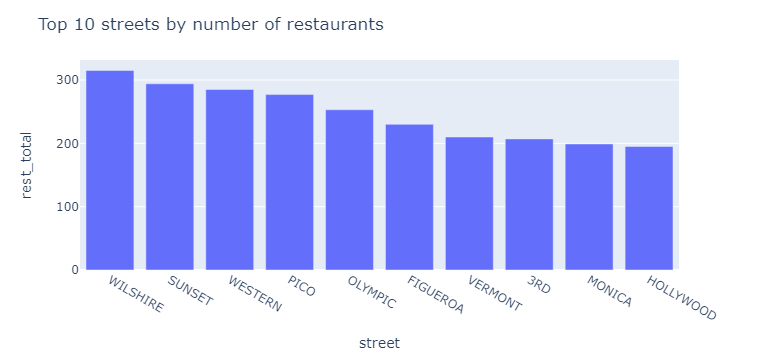

In [95]:
fig = px.bar(rest_street.head(10), x='street', y='rest_total')
fig.update_layout(title='Top 10 streets by number of restaurants')
fig.show()

**So**, the top 10 streets by number of restaurants are:
- WILSHIRE 
- SUNSET
- WESTERN
- PICO
- OLYMPIC
- FIGUEROA
- VERMONT
- 3RD
- MONICA
- HOLLYWOOD.

These are most popular streets in LA, number of restautants there varies from 195(Holliwood blvd) to 315 (Wilshire blvd).

## Find the number of streets that only have one restaurant.


We saw that more than 25 % of streets have just 1 restaurant, but how many streets exactly?

In [96]:
rest_street.query('rest_total == 1')['street'].count()

179

In [97]:
rest_street.rest_total. value_counts(normalize = True).head(10)

1     0.415313
2     0.113689
3     0.085847
4     0.041763
10    0.027842
5     0.025522
6     0.020882
14    0.016241
7     0.013921
8     0.013921
Name: rest_total, dtype: float64

**So**, streets that only have 1 restaurant make 41.5% of data (179 out of 431). 

## For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?

We saw that only 25 % of streets have more than 10 restaurants. Let's call it pop_streets and look at the distribution of the number of seats.

In [98]:
pop_street=rest_street[rest_street.rest_total > 10]
pop_street.head()

,street,rest_total,avg_seating
0,WILSHIRE,315,38.0
1,SUNSET,294,38.0
2,WESTERN,285,34.0
3,PICO,277,29.0
4,OLYMPIC,253,31.0


In [99]:
pop_street.describe()

,rest_total,avg_seating
count,99.000000,99.000000
mean,63.898990,29.449495
std,70.772486,9.891115
min,11.000000,7.000000
25%,20.000000,23.750000
50%,38.000000,29.000000
75%,69.000000,35.000000
max,315.000000,88.000000


There are 99 pop_streets with number of restaurants from 11 to 315. The number of seats varies from 7 to 88, the mean and the average are almost equal(29.4 - 29.0), so the distribution should be normal. Let'svisualize it with scatterplot.

/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/opt/conda/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



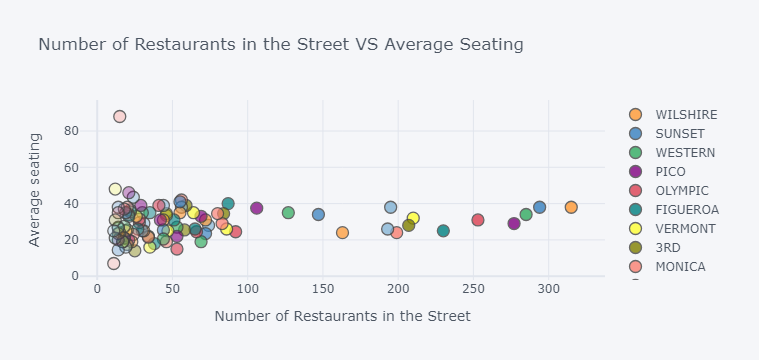

In [100]:
pop_street.iplot(
    x='rest_total',
    y='avg_seating',

    # Specify the category
    categories='street',
    xTitle='Number of Restaurants in the Street',
    yTitle='Average seating',
    title='Number of Restaurants in the Street VS Average Seating')

In [101]:
#check correlation
pop_street['rest_total'].corr(pop_street['avg_seating'])


0.10195782856349954

No correlation was found between number of restaurants in the street and average seating.

The plot shows that the majority of streets is clustered in a small area: 11-90 restaurants per street, 14-40 seats per restautant. There is an absolute outlier - Center street, which has 15 big restaurants(avg_seating = 88), and some popular streets with more than 100 objects and on average 20-40 number of seats per object. It depends on the length of the street and neighborhood itself. Center street is rather short(less than 1 mile), while most popular Wilshire, Sunset and Western streets are much longer(15.8, 22, 29 miles), so maybe we should compare streets by the number of restaurants per mile? 

**Generally** we see that the most preferable restaurant format is 20-40 seats per object for streets with a lot of restaurants as well as for streets with smaller number of restaurants, too.

## Draw an overall conclusion and provide recommendations on restaurant type and number of seats. Comment on the possibility of developing a chain.

We worked with the data on restaurants in LA stored in a dataframe with 6 columns 9651 rows. The were no duplicates, only 3 missing values(successfully filled), but a lot ob issues with object names and addresses. When object names and addresses were cleaned,  many duplicates were revealed and filtered out.

New filtered df contains 9498 rows (153 rows were dropped - 1,6%), representing unique establishments in LA. Columns with filtered object name and address were added, street name was extracted from the object's address and also stored in a separate column.

Data analysis lead to the following **conclusions**:
- The proportions of various types of establishments are:
    - Restaurant 75.3%
    - Fast Food 11 %
    - Cafe 4.5%
    - Pizza 3.3%
    - Bar 3%
    - Bakery3%

- The proportions of chain and nonchain establishments: 38% VS 62%, or 3589 chain establishments VS 5909 nonchain establishments.

- The share of chain objects in each type differs a lot: Bakery is typically a chain, 100% of Bakeries are chain objects. The share of chain objects is also very big among cafes(266 VS 169) and fastfood(605 VS 461). On the other pole are bars and restaurants, where nonchain objects prevail(215 VS 77, 4963 VS 2292). Pizzas are split almost equally in half.

- What characterizes chains:  the majority of chain objects have small number of establishments with no matter what number of seats. There are some outliers like 'Subway' chain - 148 objects with 16 average seating, Starbucks - 125 objects with 25 avg.seating, Mcdonald's - 81 object with 91 avg.seating. Chains with more than 100 avg.seating don't have many objects. If we devide chains into 4 groups by small/big number of objects and small/big average seating, we find that  many establishments with a small number of seats are more typical of chains than a few establishments with a lot of seats(513 VS 118). But the biggest group constitute chains with a few objects(<=2) and <=40 seats. Still, there is no definite correlation between average number of seats and number of establishments in a chain.

- Average number of seats for each type: 
    - Restaurant 29, 
    - Bar 28,
    - Cafe 21,
    - Fast Food 21,
    - Pizza 19,
    - Bakery 18.

On average, restaurants have the greatest number of seats.
When we differenciate between chain/nonchain objects, the picture changes. Although average restaurant is bigger than average bar, nonchain bars on average have more seats than nonchain restaurants. Chain cafes and fastfoods have more seats than nonchain establishments, all bakeries are chain, and the other types(bar, restaurant and pizza) have more seats in nonchain objects.

- The top 10 streets by number of restaurants are:
    - WILSHIRE 
    - SUNSET
    - WESTERN
    - PICO
    - OLYMPIC
    - FIGUEROA
    - VERMONT
    - 3RD
    - MONICA
    - HOLLYWOOD.
These are most popular streets in LA,  where the number of restautants there varies from 195(Holliwood blvd) to 315 (Wilshire blvd).

- Streets that only have 1 restaurant make 41.5% of data (179 out of 431).

- Distribution of the number of seats for streets with a lot of restaurants:
the majority of streets is clustered in a small area: 11-90 restaurants per street, 14-40 seats per restautant. Center street is an absolute outlier with 15 big restaurants(avg_seating = 88). Most popular streets with more than 100 objects have on average 20-40 number of seats per object. The difference depends not only on the district popularity, but also on the length of the street: Center street is rather short(less than 1 mile), while most popular Wilshire, Sunset and Western streets are much longer(15.8, 22, 29 miles according to Google).

Generally we see that the most preferred restaurant format is 20-40 seats per object for streets with a lot of restaurants as well as for streets with smaller number of restaurants, too.

So, famous chains (like Mcdonald's /Subway /Starbucks...) can afford opening a new location with big number of seats(90+) in a popular street with many visitors, the same with new nonchain restaurant or bar.  The most reliable format is 20-40 seats per bar/restaurant/fastfood.  Nonchain bar, restaurant and pizza on average will have more seats than chain objects. Bakeries are more standardized, all chain objects with average number of seats 18.

A new nonchain cafe should not be big, best up to 20 seats, the success largely depends on the location itself. If there are  already some establishments around, this would not stop from being successful, if the street is popular.

Presentation: <https://1drv.ms/b/s!AkuJ6cP2zdZSjh8szgc7D2QtRmsp?e=ju4UKZ>